# 1 Time Series 7-Day Forecasting with multi-layer perceptron (MLP)<a id='1_time_series_7-day_forecasting_with_mlp'></a>

## 1.1 Contents<a id='1.1_contents'></a>
* [1 Time series 7-day forecasting with MLP](#1_time_series_7-day_forecasting_with_mlp)
  * [1.1 Contents](#1.1_contents)  
  * [1.2 Imports](#1.2_imports)
  * [1.3 Functions](#1.3_functions)
      * [1.3.1 Function: feature_list](#1.3.1_feature_list)
      * [1.3.2 Function: ebd_dim](#1.3.2_ebd_dim)
      * [1.3.3 Function: split_sequences](#1.3.3_split_sequences)
      * [1.3.4 Function: to_embed](#1.3.4_to_embed)
      * [1.3.5 Function: build_MLP with embeddings](#1.3.5_build_MLP_with_embeddings)
      * [1.3.6 Function: ndarray_to_input_list](#1.3.6_ndarray_to_input_list)
      * [1.3.7 Function: ginic](#1.3.7_ginic)
      * [1.3.8 Function: gini_normalizedc](#1.3.8_gini_normalizedc)
      * [1.3.9 Functions: rmse_y_y_pred](#1.3.9_rmse_y_y_pred)
      * [1.3.10 Functions: plot_test_set](#1.3.10_plot_test_set)
  * [1.5 Preprocessing](#1.5_preprocessing)
      * [1.5.1 Preprocessing: get feature and target for model training and testing with cross-validation](#1.5.1_get_feature_target)
      * [1.5.2 Preprocessing: scale feature and target variables](#1.5.2_scale_feature_target)  
  * [1.6 Train and test the MLP model](#1.6_train_test_model)
      * [1.6.1 Train and test the MLP model: train and test with cross-validation](#1.6.1_train_test_crossvalidation)
      * [1.6.2 Summary and plot the model](#1.6.2_summary_plot_model)
  * [1.7 Organize and evaluate model performance](#1.7_organize_evaludate_model)
      * [1.7.1 Organize and evaluate model performance: train set](#1.7.1_organize_evaludate_model_train)
      * [1.7.2 Organize and evaluate model performance: validation set](#1.7.2_organize_evaludate_model_validation)
      * [1.7.3 Organize and evaluate model performance: test set](#1.7.3_organize_evaludate_model_test)
      * [1.7.4 Organize and evaluate model performance: save](#1.7.4_organize_evaludate_model_save)
      * [1.7.5 Organize and evaluate model performance: plot](#1.7.5_organize_evaludate_model_plot)

## 1.2 Imports<a id='1.2_imports'></a>

In [17]:
from google.colab import drive # (in Colab)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# The version needs to be identical to the version used to save the pickle file with pd.dataframes
!pip install pandas==1.3.1 
!pip install scipy==1.6.2
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3 MB 1.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [35]:
#import sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.2.post1.


In [1]:
import os
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from datetime import date, timedelta
#from isoweek import Week
import math
import warnings; warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout
from keras.layers.embeddings import Embedding
from keras.utils.vis_utils import plot_model

from contextlib import redirect_stdout
%matplotlib inline

In [2]:
#print(pd.show_versions())

## 1.3 Functions<a id='1.3_functions'></a>

#### 1.3.1 Functions: feature_list <a id='1.3.1_feature_list'></a>

In [3]:
# organize features in each row into 1) static categorical, 2) temporal categorical, 3) temporal continuous
def feature_list(country_id, row): 
    # Static Categorical
    country = country_id #0 country id
    # Temporal Categorical (datetime variables)
    dt = row[0].to_pydatetime()
    year = dt.year #1
    month = dt.month #2
    day = dt.day #3
    week_of_year = dt.isocalendar()[1] #4
    day_of_week = row[1].dayow #5
    holiday = row[1].holiday #6 holiday
    # Temporal Continuous (mobility variables)
    rtrc = row[1].rtrc #7 retail & recreation
    grph = row[1].grph #8 grocery & pharmacy
    prks = row[1].prks #9 parks
    tran = row[1].tran #10 transportation
    work = row[1].work #11 workplace
    resi = row[1].resi #12 residential area
    # Temporal Continuous (weather variables)
    cloudcover = float(row[1].cloudcover) #13 weather; cloudcover
    tempC = float(row[1].tempC) #14 weather; temparature
    humidity = float(row[1].humidity) #15 weather; humidity
    precipMM = float(row[1].precipMM) #16 weather; precipitation
    # Temporal Continuous (vaccination)
    vac = row[1].vac #17 vaccination
            
    return [country], \
[year, month, day, week_of_year, day_of_week, holiday], \
[rtrc, grph, prks, tran, work, resi, cloudcover, tempC, humidity, precipMM, vac] # Static Categorical, Temporal Categorical, Temporal Continuous

#### 1.3.2 Functions: ebd_dim <a id='1.3.2_ebd_dim'></a>

In [4]:
# determine the embedding dimensions
def ebd_dim(cat_dim):
    return min(600, round(1.6 * cat_dim ** .56))

#### 1.3.3 Functions: split_sequences <a id='1.3.3_split_sequences'></a>

In [5]:
# get the input and output sequences from the entire time series
def split_sequences(sequences, timestamp, n_steps_in, n_steps_out): 
    timestamps = sequences.index
    df_time0 = timestamps[0]
    df_time_end = timestamps[-1]
    dt_steps_in = timedelta(days=n_steps_in)
    dt_steps_out = timedelta(days=n_steps_out-1)   
    dt_1 = timedelta(days=1)
    if (timestamp-dt_steps_in>=df_time0) & (timestamp+dt_steps_out<=df_time_end): # if within bounds
        # gather input and output parts of the pattern 
        seq_x = sequences[timestamp-dt_steps_in:timestamp-dt_1] # input sequence (e.g. previous 14 days) 
        seq_y = sequences[timestamp:timestamp+dt_steps_out] # output sequence (e.g. next 7 days including the current timestamp)
    return list(seq_x), list(seq_y)

#### 1.3.4 Functions: to_embed <a id='1.3.4_to_embed'></a>

In [6]:
# preprocess the embedding columns
def to_embed(cat_columns): 
    
    cat_conv_raw = []
    cat_conv_array = np.empty((cat_columns.shape[0],cat_columns.shape[1]))
    
    for c in range(cat_columns.shape[1]):
        cat_conv_raw.append(list(cat_columns[:,c]))
        raw_vals = np.unique(cat_columns[:,c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i
        cat_conv_array[:,c] = [val_map[j] for j in cat_conv_raw[c]]
    return cat_conv_array

#### 1.3.5 Functions: build_MLP_with_embeddings<a id='1.3.5_build_MLP_with_embeddings'></a>

In [7]:
def build_MLP_with_embeddings(): 
    
    inputs = []
    embeddings = []
    input_dims = []
    
    input_stat_cat_00_country = Input(shape=(1,)) # country (0)
    embedding = Embedding(23, 9, input_length=1)(input_stat_cat_00_country)
    embedding = Reshape(target_shape=(9,))(embedding)
    inputs.append(input_stat_cat_00_country)
    embeddings.append(embedding)
    input_dims.append(input_stat_cat_00_country.shape[-1])
    
    input_temp_cat_01_year = Input(shape=(1,)) # year (1)
    embedding = Embedding(2, 1, input_length=1)(input_temp_cat_01_year)
    embedding = Reshape(target_shape=(1,))(embedding)
    inputs.append(input_temp_cat_01_year)
    embeddings.append(embedding)
    input_dims.append(input_temp_cat_01_year.shape[-1])
     
    input_temp_cat_02_month = Input(shape=(1,)) # month (2)
    embedding = Embedding(12, 6, input_length=1)(input_temp_cat_02_month)
    embedding = Reshape(target_shape=(6,))(embedding)
    inputs.append(input_temp_cat_02_month)
    embeddings.append(embedding)    
    input_dims.append(input_temp_cat_02_month.shape[-1])
    
    input_temp_cat_03_day = Input(shape=(1,)) # day (3)
    embedding = Embedding(31, 11, input_length=1)(input_temp_cat_03_day)
    embedding = Reshape(target_shape=(11,))(embedding)
    inputs.append(input_temp_cat_03_day)
    embeddings.append(embedding)    
    input_dims.append(input_temp_cat_03_day.shape[-1])
    
    input_temp_cat_04_week_of_year = Input(shape=(1,)) # week of year (4)
    embedding = Embedding(53, 15, input_length=1)(input_temp_cat_04_week_of_year)
    embedding = Reshape(target_shape=(15,))(embedding)
    inputs.append(input_temp_cat_04_week_of_year)
    embeddings.append(embedding) 
    input_dims.append(input_temp_cat_04_week_of_year.shape[-1])
    
    input_temp_cat_05_day_of_week = Input(shape=(1,)) # day of week (5)
    embedding = Embedding(7, 5, input_length=1)(input_temp_cat_05_day_of_week)
    embedding = Reshape(target_shape=(5,))(embedding)
    inputs.append(input_temp_cat_05_day_of_week)
    embeddings.append(embedding) 
    input_dims.append(input_temp_cat_05_day_of_week.shape[-1])
    
    input_temp_cat_06_holiday = Input(shape=(1,)) # holiday (6)
    embedding = Embedding(2, 2, input_length=1)(input_temp_cat_06_holiday)
    embedding = Reshape(target_shape=(2,))(embedding)
    inputs.append(input_temp_cat_06_holiday)
    embeddings.append(embedding)  
    input_dims.append(input_temp_cat_06_holiday.shape[-1])
    
    input_numeric = Input(shape=(25,)) # all temporal continuous features (mobility, weather, vaccination)
    dense_numeric = Dense(19)(input_numeric)
    inputs.append(input_numeric)
    embeddings.append(dense_numeric)
    input_dims.append(input_numeric.shape[-1])
    
    x = Concatenate()(embeddings)
    x = Dense(90, activation='relu')(x)
    x = Dropout(.35)(x)
    x = Dense(40, activation='relu')(x)
    x = Dropout(.15)(x)
    x = Dense(10, activation='relu')(x)
    x = Dropout(.15)(x)
    output = Dense(7, activation='linear')(x)
    
    model = Model(inputs, output)
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    return model, input_dims
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# print(model.summary())

#### 1.3.6 Functions: ndarray_to_input_list <a id='1.3.6_ndarray_to_input_list'></a>

In [8]:
def ndarray_to_input_list(ndarr,input_dims): 
    input_list = []
    input_dim_cumsum = list(np.cumsum(input_dims))
    input_dim_cumsum.insert(0,0)
    curr_input_0 = input_dim_cumsum[:-1]
    for i,input_0 in enumerate(curr_input_0):
        input_list.append(ndarr[:,input_0:input_0+input_dims[i]])
    return input_list

#### 1.3.7 Functions: ginic <a id='1.3.7_ginic'></a>

In [9]:
#gini scoring function from kernel at: 
#https://www.kaggle.com/tezdhar/faster-gini-calculation
def ginic(actual, pred):
    pred_arr = np.asarray(pred)
    if len(pred_arr.shape)==2: # matrix 
        pred_mean = pred.copy()
    elif len(pred_arr.shape)==3: # tuple 
        pred_mean = np.nanmean(pred_arr,axis=0) # average across cross-validation folds
    n, c = actual.shape[0], actual.shape[1]
    gini_sum = []
    for col in range(c):
        a_s = actual[np.argsort(pred_mean[:,col]),col] # returns the indices that would sort an array
        a_c = a_s.cumsum()
        gini_sum.append((a_c.sum() / a_c[-1] - (n + 1) / 2.0)/n) 
    return gini_sum

#### 1.3.8 Functions: gini_normalizedc <a id='1.3.8_gini_normalizedc'></a>

In [10]:
def gini_normalizedc(a, p):
    gini_a_p = ginic(a, p)
    gini_a_a = ginic(a, a)
    gini_norm = [gini_a_p[i]/gini_a_a[i] for i in range(len(gini_a_p))]
    return gini_norm

#### 1.3.9 Functions: rmse_y_y_pred <a id='1.3.9_rmse_y_y_pred'></a>

In [11]:
def rmse_y_y_pred(rez_dict, n_steps_out):
    rmse_dict = {}
    countries = sorted(set(rez_dict['country']))
    for country in countries:
        country_idx = [cc==country for cc in rez_dict['country']]
        country_rmse = []
        for d in range(n_steps_out):
            country_rmse.append(mean_squared_error(rez_dict['y'][country_idx,d], rez_dict['y_pred'][country_idx,d], squared=False))
        rmse_dict[country] = country_rmse
    return rmse_dict 

#### 1.3.10 Functions: plot_test_set <a id='1.3.10_plot_test_set'></a>

In [23]:
def plot_test_set(rez_dict, dict_country, save_name, n_steps_out=7):
    countries = sorted(set(rez_dict['country']))
    # plot for each of the 7-day forecast
    for country in countries:
        fig, ax = plt.subplots(n_steps_out, 1, figsize=(12, 36))
        fig.subplots_adjust(wspace=0.5, hspace=0.7)
        
        country_idx = [cc==country for cc in rez_dict['country']]
        timestamps = [i for i,v in zip(rez_dict['timestamp'],country_idx) if v]
        
        holidays = np.array(dict_country[country].loc[timestamps, 'holiday']==1) # holidays
        sundays = np.array(dict_country[country].loc[timestamps, 'dayow']==6) # Sundays
        holi_sun = np.logical_or(holidays, sundays)
        holiday_timestamps = [date.strftime(i, '%b-%d') for i,v in zip(rez_dict['timestamp'],holi_sun) if v]
        
        y_actual = rez_dict['y'][country_idx,:]
        y_pred = rez_dict['y_pred'][country_idx,:]
        
        for i in range(n_steps_out):
            ts_td = [t+timedelta(days=i) for t in timestamps]
            ts = list(map(lambda x:date.strftime(x,'%b-%d'),ts_td))           
            ax[i].plot(ts, y_actual[:,i], 'o-')
            ax[i].plot(ts, y_pred[:,i], 'o-')
            ax[i].set_xlabel('Date', fontsize=10, fontweight='bold')
            ax[i].set_xlim(ts[0], ts[-1])
            ax[i].set_ylabel('Cases per million', fontsize=10, fontweight='bold')          
            ax[i].set_title(country + '_step_#' + str(i), fontweight='bold', fontsize=14)
            ax[i].legend(['y_actual','y_pred'], prop=dict(weight='bold',size=8))
            for tick in ax[i].get_xticklabels():
                tick.set_rotation(45)
            ax[i].tick_params(axis='x', labelsize=8)
            for holi in holiday_timestamps:
                ax[i].axvspan(holi, holi, color='red', alpha=0.3, linewidth=2)
        # figure save
        fig.savefig(os.path.join('/content/drive/My Drive/Colab_data/covid19/Figure', \
                                 country+'_'+save_name+'_MLP_7d.pdf'), tranparent=True)

## 1.4 Load data<a id='1.4_load_data'></a>

In [13]:
# load data from pickle file
filePath_pickle = Path('/content/drive/My Drive/Colab_data/covid19/covid_country_data.pickle')
with open(filePath_pickle, 'rb') as f:
    dict_country = pd.read_pickle(f)
# countries = ['AR', 'AT', 'AU', 'BE', 'CA', 'DE', 'DK', 'FI', 'FR', 'GB', 'ID', 'IE', 'IL', 'IN', 'IT', 'JP', 'KR', 'MX', 'NL', 'NO', 'RU', 'SG', 'US']

## 1.5 Preprocessing <a id='1.5_Preprocessing'></a>

#### 1.5.1 Preprocessing: get feature and target for model training and testing with cross-validation <a id='1.5.1_get_feature_target'></a>

In [14]:
train_timestamp = []
train_country = []
train_stat_cat = []
train_temp_cat = []
train_temp_con = []
train_feature_case = []
train_y_unscaled = []
test_timestamp = []
test_country = []
test_stat_cat = []
test_temp_cat = []
test_temp_con = []
test_feature_case = []
test_y_unscaled = []

n_test = 50 # days
dt_test = timedelta(days=n_test-1)
n_steps_in = 14 # days (# previous cases)
dt_steps_in = timedelta(days=n_steps_in)
n_steps_out = 7 # days (# future cases to be predicted)
dt_steps_out = timedelta(days=n_steps_out-1)

for i, country_key in enumerate(dict_country.keys()):
    case_detection = 0
    df_country = dict_country[country_key]
    df_country.fillna(method='ffill',inplace=True) # forward fill NaNs
    df_time0 = df_country.index[0] # the first day of the data
    df_time_end = df_country.index[-1] # the last day of the data
    # split the df into train and test sets
    test_time0 = df_country.index[-1]-dt_test # the first date of test set 
    train_ind = df_country.index < test_time0 # training index
    # feature_list train 
    df_country_train = df_country.loc[train_ind] # train df
    for row in df_country_train.iterrows():
        ts_curr = row[0] 
        # case_mil lagging
        if (ts_curr-dt_steps_in>=df_time0) & (ts_curr+dt_steps_out<=df_time_end):
            # get feature and target variables
            feature_case, target_case = split_sequences(df_country['case_mil'], ts_curr, n_steps_in, n_steps_out)         
            if (case_detection == 0) & (sum(feature_case)>0): # to exclude days before 1st case detection
                case_detection = 1
            if case_detection == 1:
                fl_stat_cat, fl_temp_cat, fl_temp_con = feature_list(i, row) # get static categorical, temporal categorical, temporal continuous variables separately 
                # train data X
                train_country.append(row[1].country_region_code)
                train_timestamp.append(ts_curr) # timestamps
                train_stat_cat.append(fl_stat_cat) # static categorical 
                train_temp_cat.append(fl_temp_cat) # temporal categorical 
                train_temp_con.append(fl_temp_con) # temporal continuous
                train_feature_case.append(feature_case) # case_mil previous days to be used as features
                # train data y
                train_y_unscaled.append(target_case) # case_mil current & future days to be predicted
    # feature list test
    df_country_test = df_country.loc[~train_ind] # test df
    # feature list test 
    for row in df_country_test.iterrows():
        ts_curr = row[0]
        # case_mil lagging
        if (ts_curr-dt_steps_in>=df_time0) & (ts_curr+dt_steps_out<=df_time_end):        
            # get feature and target variables
            feature_case, target_case = split_sequences(df_country['case_mil'], ts_curr, n_steps_in, n_steps_out) 
            fl_stat_cat, fl_temp_cat, fl_temp_con = feature_list(i, row) # get static categorical, temporal categorical, temporal continuous variables separately
            # test data X
            test_country.append(row[1].country_region_code)
            test_timestamp.append(ts_curr)
            test_stat_cat.append(fl_stat_cat) # static categorical 
            test_temp_cat.append(fl_temp_cat) # temporal categorical 
            test_temp_con.append(fl_temp_con) # temporal continuous
            test_feature_case.append(feature_case) # case_mil previous days to be used as features
            # train data y
            test_y_unscaled.append(target_case) # case_mil current & future days to be predicted

#### 1.5.2 Preprocessing: scale feature and target variables <a id='1.5.2_scale_feature_target'></a>

In [15]:
# convert list to ndarray
train_stat_cat_embed = to_embed(np.array(train_stat_cat))
train_temp_cat_embed = to_embed(np.array(train_temp_cat))
train_temp_con = np.array(train_temp_con)
train_feature_case = np.reshape(train_feature_case, (len(train_timestamp), n_steps_in))
train_y_unscaled = np.reshape(train_y_unscaled, (len(train_timestamp), n_steps_out))
test_stat_cat_embed = to_embed(np.array(test_stat_cat))
test_temp_cat_embed = to_embed(np.array(test_temp_cat))
test_temp_con = np.array(test_temp_con)
test_feature_case = np.reshape(test_feature_case, (len(test_timestamp), n_steps_in))
test_y_unscaled = np.reshape(test_y_unscaled, (len(test_timestamp), n_steps_out))
# scale the temporal continuous variables
temp_con_scaler = MinMaxScaler()
temp_con_scaler.fit(train_temp_con)
train_temp_con_scaled = temp_con_scaler.transform(train_temp_con)
test_temp_con_scaled = temp_con_scaler.transform(test_temp_con)
# scale feature and target cases (case_mil)
scaler_feature_case = StandardScaler()
scaler_y = StandardScaler()
case_all_1d = np.concatenate((train_feature_case.reshape(-1,1), test_feature_case.reshape(-1,1),\
                            train_y_unscaled.reshape(-1,1), test_y_unscaled.reshape(-1,1)),axis=0)
y_all_feature = np.matlib.repmat(case_all_1d, 1, train_feature_case.shape[1])
y_all_test = np.matlib.repmat(case_all_1d, 1, train_y_unscaled.shape[1])

scaler_feature_case.fit(y_all_feature)
scaler_y.fit(y_all_test)

train_feature_case_scaled = scaler_feature_case.transform(train_feature_case)
test_feature_case_scaled = scaler_feature_case.transform(test_feature_case)

train_y = scaler_y.transform(train_y_unscaled)
test_y = scaler_y.transform(test_y_unscaled)
# concatenate
train_X = np.concatenate((train_stat_cat_embed, train_temp_cat_embed, train_temp_con_scaled, train_feature_case_scaled), axis=1)
test_X = np.concatenate((test_stat_cat_embed, test_temp_cat_embed, test_temp_con_scaled, test_feature_case_scaled), axis=1)
print("Number of train datapoints: ", len(train_y))
print("Number of test datapoints: ", len(test_y))

Number of train datapoints:  11874
Number of test datapoints:  1012


## 1.6 Train and test the MLP model <a id='1.6_train_test_model'></a>

#### 1.6.1 Train and test the MLP model: train and test with cross-validation <a id='1.6.1_train_test_crossvalidation'></a>

In [16]:
# get the cross-validation folds for train and validation sets  
train_folds = []
validation_folds = []
# get the timestamps for train and validation folds
sorted_train_timestamp = sorted((set(train_timestamp))) # unique timestamps in the train set
tscv = TimeSeriesSplit(n_splits=5, test_size=20) # splitting train and validations sets for cross validation
for train_idx, validation_idx in tscv.split(sorted_train_timestamp): # get train and validation sets
    # print("TRAIN:", train_idx, "VALIDATION:", validation_idx)
    train_folds.append([sorted_train_timestamp[i] for i in train_idx]) # folds in train set
    validation_folds.append([sorted_train_timestamp[i] for i in validation_idx]) # folds in validation set

n_epochs = 100
runs_per_fold = 20

cv_ginis = []
train_preds = []
train_idx_fold = [] 
val_preds = []
val_idx_fold = []
test_preds = []

# network training
for fold in range(len(train_folds)): # iterate cross-validation folds
    fold_idx_train = [ts in train_folds[fold] for ts in train_timestamp]
    train_idx_fold.append(fold_idx_train)
    fold_idx_val = [ts in validation_folds[fold] for ts in train_timestamp]
    val_idx_fold.append(fold_idx_val)
    X_train_f, X_val_f = train_X[fold_idx_train,:], train_X[fold_idx_val,:] # X_train for the current fold
    y_train_f, y_val_f = train_y[fold_idx_train,:], train_y[fold_idx_val,:] # y_train for the current fold
    
    train_preds_fold = []
    val_preds_fold = []
    
    for run_n in range(runs_per_fold): # iterate # of runs per fold
        # build the model
        NN, input_dim_NN = build_MLP_with_embeddings() # build the model and get input dimensions
        
        X_train_f_input = ndarray_to_input_list(X_train_f, input_dim_NN)
        X_val_f_input = ndarray_to_input_list(X_val_f, input_dim_NN)
        X_test_f_input = ndarray_to_input_list(test_X, input_dim_NN)
        
        NN.fit(X_train_f_input, y_train_f, epochs=n_epochs, batch_size=2048, verbose=0)
   
        train_preds_fold.append(NN.predict(X_train_f_input))
        val_preds_fold.append(NN.predict(X_val_f_input))
        test_preds.append(NN.predict(X_test_f_input))
    
    cv_gini = gini_normalizedc(y_val_f, val_preds_fold) # actual, predicted
    cv_ginis.append(cv_gini)
    for i, cvg in enumerate(cv_gini):
        print('\nFold %d prediction cv gini_%d: %.5f\n' %(fold,i,cv_gini[i]))
    
    train_preds.append(np.mean(np.asarray(train_preds_fold),axis=0)) # ave
    val_preds.append(np.mean(np.asarray(val_preds_fold),axis=0))
    
cv_gini_mean = np.nanmean(np.asarray(cv_ginis),axis=0)
for i, g in enumerate(cv_gini_mean):
    print('Mean validation fold gini_%d: %.5f\n' %(i,g))

test_y_pred = np.nanmean(np.asarray(test_preds),axis=0) # average across cross-validation folds and runs


Fold 0 prediction cv gini_0: 0.95017


Fold 0 prediction cv gini_1: 0.95099


Fold 0 prediction cv gini_2: 0.94897


Fold 0 prediction cv gini_3: 0.94936


Fold 0 prediction cv gini_4: 0.94815


Fold 0 prediction cv gini_5: 0.95031


Fold 0 prediction cv gini_6: 0.94917


Fold 1 prediction cv gini_0: 0.95933


Fold 1 prediction cv gini_1: 0.95567


Fold 1 prediction cv gini_2: 0.95602


Fold 1 prediction cv gini_3: 0.95523


Fold 1 prediction cv gini_4: 0.95583


Fold 1 prediction cv gini_5: 0.95725


Fold 1 prediction cv gini_6: 0.94839


Fold 2 prediction cv gini_0: 0.95813


Fold 2 prediction cv gini_1: 0.95553


Fold 2 prediction cv gini_2: 0.94440


Fold 2 prediction cv gini_3: 0.93760


Fold 2 prediction cv gini_4: 0.92389


Fold 2 prediction cv gini_5: 0.91274


Fold 2 prediction cv gini_6: 0.90298


Fold 3 prediction cv gini_0: 0.94389


Fold 3 prediction cv gini_1: 0.93625


Fold 3 prediction cv gini_2: 0.92484


Fold 3 prediction cv gini_3: 0.90937


Fold 3 prediction cv gin

#### 1.6.2 Summary and plot the MLP model <a id='1.6.2_summary_plot_model'></a>

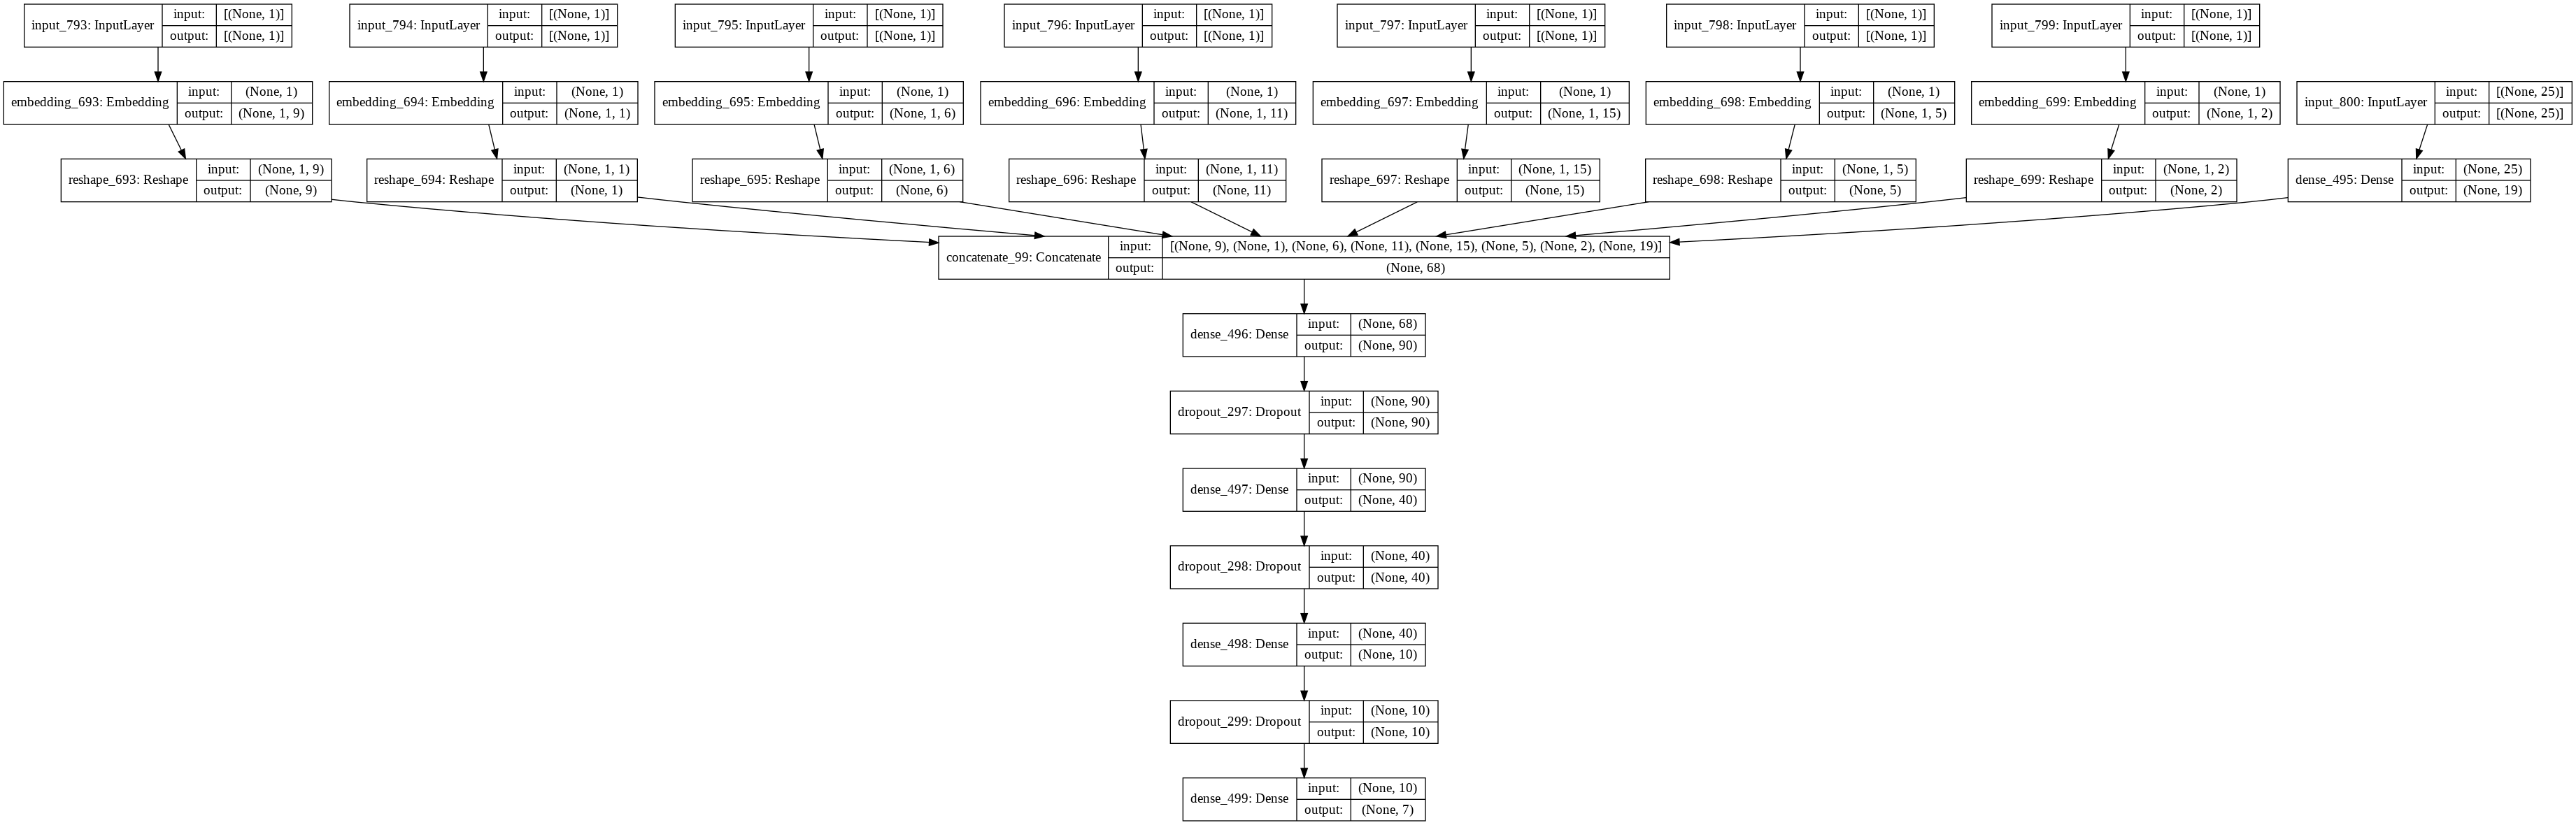

In [17]:
plot_model(NN, to_file='/content/drive/My Drive/Colab_data/covid19/model_plot_MLP_7d.png', show_shapes=True, show_layer_names=True)

In [18]:
print(NN.summary())
with open('/content/drive/My Drive/Colab_data/covid19/model_summary_MLP_7d.txt', 'w') as f:
    with redirect_stdout(f):
        NN.summary()

Model: "model_99"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_793 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_794 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_795 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_796 (InputLayer)          [(None, 1)]          0                                            
___________________________________________________________________________________________

## 1.7 Organize and evaluate model performance <a id='1.7_organize_evaludate_model'></a>

#### 1.7.1 Organize and evaluate model performance: train set <a id='1.7.1_organize_evaludate_model_train'></a>

In [19]:
# average train_preds across folds to get train_y_pred
train_y_pred_fold = numpy.empty((len(train_idx_fold[0]), n_steps_out, len(train_idx_fold)))
train_y_pred_fold[:]=np.NaN
for i, train_idx in enumerate(train_idx_fold): 
    train_y_pred_fold[train_idx,:,i] = train_preds[i]
train_y_pred = np.nanmean(train_y_pred_fold, axis=2)

rez_MLP_7d_train = {}
train_set_idx = np.isnan(train_y_pred).sum(axis=1)==0
rez_MLP_7d_train['timestamp'] = [train_timestamp[i] for i, logic in enumerate(train_set_idx) if logic ==True]
rez_MLP_7d_train['country'] = [train_country[i] for i, logic in enumerate(train_set_idx) if logic ==True]
rez_MLP_7d_train['X'] = train_X[train_set_idx,:] # note that variables are scaled and preprocessed for embedding 
rez_MLP_7d_train['y'] = scaler_y.inverse_transform(train_y)[train_set_idx,:] # back to the original unit (cases per million)
rez_MLP_7d_train['y_pred'] = scaler_y.inverse_transform(train_y_pred)[train_set_idx,:] 
rez_MLP_7d_train['rmse'] = rmse_y_y_pred(rez_MLP_7d_train, n_steps_out)

#### 1.7.2 Organize and evaluate model performance: validation set <a id='1.7.2_organize_evaludate_model_validation'></a>

In [20]:
# average val_preds across folds to get val_y_pred
val_y_pred_fold = numpy.empty((len(train_idx_fold[0]), n_steps_out, len(train_idx_fold)))
val_y_pred_fold[:]=np.NaN
for i, val_idx in enumerate(val_idx_fold): 
    val_y_pred_fold[val_idx,:,i] = val_preds[i]
val_y_pred = np.nanmean(val_y_pred_fold, axis=2)

rez_MLP_7d_val = {}
val_set_idx = np.isnan(val_y_pred).sum(axis=1)==0
rez_MLP_7d_val['timestamp'] = [train_timestamp[i] for i, logic in enumerate(val_set_idx) if logic ==True]
rez_MLP_7d_val['country'] = [train_country[i] for i, logic in enumerate(val_set_idx) if logic ==True]
rez_MLP_7d_val['X'] = train_X[val_set_idx,:] # note that variables are scaled and preprocessed for embedding 
rez_MLP_7d_val['y'] = scaler_y.inverse_transform(train_y)[val_set_idx,:] # back to the original unit (cases per million)
rez_MLP_7d_val['y_pred'] = scaler_y.inverse_transform(val_y_pred)[val_set_idx,:] 
rez_MLP_7d_val['rmse'] = rmse_y_y_pred(rez_MLP_7d_val, n_steps_out)

#### 1.7.3 Organize and evaluate model performance: test set <a id='1.7.3_organize_evaludate_model_test'></a>

In [21]:
rez_MLP_7d_test = {}
rez_MLP_7d_test['timestamp'] = test_timestamp
rez_MLP_7d_test['country'] = test_country
rez_MLP_7d_test['X'] = test_X # note that variables are scaled and preprocessed for embedding 
rez_MLP_7d_test['y'] = scaler_y.inverse_transform(test_y)
rez_MLP_7d_test['y_pred'] = scaler_y.inverse_transform(test_y_pred)
rez_MLP_7d_test['rmse'] = rmse_y_y_pred(rez_MLP_7d_test, n_steps_out)

#### 1.7.4 Organize and evaluate model performance: save data<a id='1.7.4_organize_evaludate_model_save'></a>

In [22]:
rez_MLP_7d = {'train':rez_MLP_7d_train, 'validation':rez_MLP_7d_val, 'test':rez_MLP_7d_test}

filePath_pickle = Path('/content/drive/My Drive/Colab_data/covid19/covid19_MLP_7d_with_lagging.pickle')
with open(filePath_pickle, 'wb') as f:
    pickle.dump(rez_MLP_7d, f)

In [ ]:
# load the saved dictionary from pickle file
# filePath_pickle = Path('/Users/parkj/Documents/pyDat/pyDatCode/covid19/covid19_MLP_7d_with_lagging.pickle')
# with open(filePath_pickle, 'rb') as f:
#     rez_MLP_7d = pickle.load(f)

#### 1.7.5 Organize and evaluate model performance: plot <a id='1.7.5_organize_evaludate_model_plot'></a>

In [24]:
plot_test_set(rez_MLP_7d_test, dict_country, 'test', n_steps_out=7)

Output hidden; open in https://colab.research.google.com to view.